<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 3: сегментация </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Третьей и заключительной такой аркой будет сегментация. 


#  Глава III (Вконтакте и его мальчик) 

In [2]:
import pandas as pd              # Пакет для работы с таблицами
import numpy as np               # Пакет для работы с векторами и матрицами

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

%matplotlib inline

# 1. Данные

Подгрузим данные по стенкам и немного посмотрим на них.  Как мы и договаривались, будем анализировать подписчиков групп с мемами. 

**нормальные мемы**

* [Хаер скул оф мемес](https://vk.com/hsemem)
* [Мемы про машиное обучение для взрослых мужиков](https://vk.com/weirdreparametrizationtrick)
* [Физкек](https://vk.com/phys_kek)
* [Абстрактные мемы для элиты всех сортов](https://vk.com/abstract_memes)

**сомнительные мемы**

* [Я смотрю украинские шоу и радуюсь жизни](https://vk.com/ukrainskieshow)
* [Female memes](https://vk.com/femalemem)


**очень очень плохие мемы**

* [Чёткие приколы](https://vk.com/oroom)
* [Остроумные](https://vk.com/ostroym)
* [Кривое зеркало (театр Евгения Петросяна)](https://vk.com/teleteatrkrivoezerkalo)



In [3]:
publics = ['hse_memes.pickle', 'ml_memes.pickle', 'amdevs.pickle', 
           'female_memes.pickle', 'fizkek.pickle', 'bad_memes1.pickle',
           'bad_memes2.pickle', 'ukr_memes.pickle', 'wtf_memes.pickle']

In [4]:
import pickle

data = [ ]

for item in publics:
    with open('../sem10_vk/' + item, 'rb') as f:
        cur_data = pickle.load(f)
    data.extend(cur_data)

In [5]:
len(data)

8989

In [6]:
data[-10]

{'group': 'wtf_memes',
 'id': 291742522,
 'wall': '  Люблю своих друзей! \n\n#деньдружбы      Дело говорил 🤔 мои глаза полны любви ❤   Офис (сериал 2005 – 2013)  Картины Адольфа Гитлера. Я по жизни месье Леон. '}

Тексты бывают очень длинными. Давайте избавимся от аномально длинных стенок. Для этого построим их распределение. 

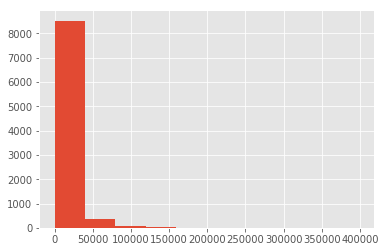

In [7]:
text_len = [len(item['wall']) for item in data]
plt.hist(text_len);

Найдём $95\%$ квантиль и срежем по немы все тексты.

In [8]:
q = np.quantile(text_len, 0.95)
q

40527.8

In [9]:
texts = [item['wall'] for item in data if len(item['wall']) < q]
group = [item['group'] for item in data if len(item['wall']) < q]

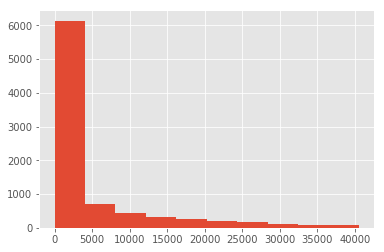

In [10]:
text_len = [len(item) for item in texts]
plt.hist(text_len);

Было стенок:

In [11]:
len(data)

8989

Стало стенок:

In [12]:
len(texts)

8539

# 2. Предобработка


Подготовим контент со стенок к дальнейшему алализу. Во-первых, приведём все слова к нижнему регистру. Во-вторых, разрубим все тексты на состовляющие их слова. Такую разрубку называют **токенизацией.** Обычно, при работе с текстами руководствуются гипотезой, которая называется **мешком слов.** Смысл этой гипотезы состоит в том, что порядок слов в предложении никак не сказывается на его смысле. 

* Порядок слов неважен
* Неважен порядок слов
* Слов порядок неважен 
* Порядок неважен слов 
* Слов неважен порядок
* Неважен слов порядок 

Конечно же с этой гипотезой можно поспорить и для этого вам придётся схлеснуться в словесной дуэли с одним известным персонажем. 

<img align="center" src="http://tvperson.ru/2014/11/yoda-3-1024x682.jpg" width="500"> 


Главным аргументом с вашей стороны, скорее всего, будет частица не, положение которой в предложении может координально влиять на смысл фразы. Да, порядок слов иногда важен. Тем не менее при моделировании мы должны чем-то жертвовать. Справедливости ради стоит отметить, что существует ряд более сложных моделей, которые учитывают порядок слов, но мы не будем их касаться в этом исследовании. По крайней мере пока. Тем более, интуиция подсказывает, что пренебрежение порядком слов не должно никак сказаться на выделении тем. 

Грубо говоря, каждое слово это регрессор. Перед каждым словом надо оценивать коэффициент. То с какой частотой оно наблюдается в статье - наше наблюдение. Наблюдений в сравнении с числом параметров, которое нужно будет оценить, очень мало. Постараемся уменьшить число регрессоров, выкинув не очень важные слова. 

Например, в текстах часто встречаются предлоги. Они не несут никакой смысловой информации о сути текста и есть почти в каждой группе. Найдётся огромное количество подобной лексики, которая для нашего набора текстов встречается повсеместно и не несёт никакой инормации. Обычно такие частые слова называют **стоп-словами.** Они путают нашу модель, перетягивая на себя внимание. От них необходимо избавиться.

Другим естественным путём для уменьшения числа регрессоров является приведение всех слов к одной форме. Всех существительных к именительному падежу и единственному числу, всех глаголов к инфинитиву и т.д. Такая обработка называется **лемматизацией.** Она делается по специальным словарям, составленным для языка. К счастью, для русского языка такой словарь реализован в ультракрутом пакете `pymystem`.

Этот пакет превратит слово люди в слово человек, слова красивая и красивые в слово красивый, слова сделал и делал в делать. Таким образом количество различных слов в словаре здорово упадёт, а смысл не пострадает. Попутно он сделает токенизацию и ещё и регистр понизит. Одним словом не пакет, а чудо. Если у вас он не установлен, запустите в отдельной ячейке команду: 

`!pip install pymystem3`

In [13]:
from pymystem3 import Mystem

m = Mystem()  # обхявили предобработчик

lemmas = m.lemmatize(texts[-1])  # натравили его на текст
print(lemmas[:50])

['    ', 'без', ' ', 'ошибка', ' ', 'проходить', ' ', 'экзамен', '.', '\n', '\n', 'учить', ' ', 'правило', ' ', 'дорожный', ' ', 'движение', ' ', 'и', ' ', 'готовиться', ' ', 'к', ' ', 'экзамен', ' ', 'на', ' ', 'получение', ' ', 'право', ' ', 'в', ' ', 'официальный', ' ', 'приложение', ' ', 'вконтакте', ' ', 'vk', '.', 'com', '/', 'pdd', ' (', 'пдд', ' ', '2019']


In [14]:
# объявили предобработчик с опцией выкидывать пробелы и пунктуацию
m = Mystem(entire_input=False)

lemmas = m.lemmatize(texts[-1])
print(lemmas[:50])

['без', 'ошибка', 'проходить', 'экзамен', 'учить', 'правило', 'дорожный', 'движение', 'и', 'готовиться', 'к', 'экзамен', 'на', 'получение', 'право', 'в', 'официальный', 'приложение', 'вконтакте', 'vk', 'com', 'pdd', 'пдд', 'встречать', 'сентябрь', 'по', 'традиция', 'якалендарьперевертывать', 'михаилшуфутинский', 'ну', 'что', 'тут', 'можно', 'сказать', 'в', 'северодвинск', 'приходить', 'долгожданный', 'апрель', 'вот', 'и', 'все', 'гораздо', 'благородно', 'чем', 'человек', 'вы', 'теперь', 'далеко', 'да']


Запустим предобработчик на всех данных. Это займёт какое-то время.

In [15]:
%%time
texts_prep = [m.lemmatize(text) for text in texts]
texts_prep[-1][:50]

CPU times: user 1min 10s, sys: 8.32 s, total: 1min 18s
Wall time: 7min 15s


Дополнительно прогоним все тексты через список стоп-слов, чтобы выбросить всякий хлам. Если на компьютере нет nltk, его придётся установить командой `!pip install nltk`. Внутри лежит куча разных полезных вещей, которые обычно применяютс для анализа текстов. 

In [ ]:
# нужно только после первой установки, чтобы скачать стоп-слова на свой комп :) 
# в nltk много других вещей, которые можно также скачать
# nltk.download("stopwords") 

In [16]:
from nltk.corpus import stopwords

# Например, там лежат стоп-слова 
stopwords_ru = stopwords.words('russian') 
stopwords_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

Очищаем каждый текст от стоп-слов.

In [17]:
texts_prep = [[word for word in text if word not in stopwords_ru] for text in texts_prep]

После предобработки лучше данные сохранить на компьютер. Делать это вы уже умеете. 

In [18]:
with open('wall_prep.pickle', 'wb') as f:
    pickle.dump(texts_prep, f)

# 3. Что такое тематическое моделирование

Пришло время обсудить то, как именно рождаются тексты. Разговаривать об этом мы будем не особо глубоко. Нашей задачей является понять то, что именно нам выдаст на выходе алгоритм. То какие именно тонкости за ним стоят и как происходит оценивание, мы опустим. Эти тонкости очень важны, но вы читаете не скучный учебник по машинному обучению, а увлекательный гранд иканам ресёрч. Поэтому мы позволим себе такую вольность и не будем говорить ни о методе максимального правдоподобия, ни о четырёх новых методах наименьших квадратов и всё такое. Обо всём этом вы поговорите на курсе или факультативе по анализу данных. Здесь же мы будем говорить о мешках и совсем немного о матрицах. Тем не менее если вы учитесь на первых курсах, иногда, число незнакомых слов будет зашкаливать. Крепитесь.

Итак, отбросим прочь все предрассудки и глупости. Наши мир создал он, великий процесс порождения данных! И каждый текст он создал в виде мешка. Мешка слов. На самом деле мешков много. И каждый мешок соответствует своей теме. Внутри мешков лежат камушки. Много камушков. На каждом камушке написано какое-то слово. Слова часто повторяются. Каждое слово повторяется разное количество раз. 

<img align="center" src="https://raw.githubusercontent.com/FUlyankin/ekanam_grand_research/master/images/3.%20publics/meshok_1.png" width="600"> 

Дальше природа подкидывает кубик с количеством граней равным количеству тем и выбирает одну из них. Кубик у природы неправильный. Разные грани выпадают на нём с разными вероятностями. Из мешка, который соответствует этой теме, природа тянет камушек.

<img align="center" src="https://raw.githubusercontent.com/FUlyankin/ekanam_grand_research/master/images/3.%20publics/meshok_2.png" width="450"> 

После природа подкидывает кубик снова, выбирает какую-то новую тему и начинает тянуть из мешка, который ей соответствует, новый камушек. Так и рождается текст.

Поговорим о порождении природой текстов чуть более научно. Будем называть каждый текст **документом, $d$.** Каждый документ состоит из нескольких **тем, $t$.** Каждая тема описывается некоторым набором **слов, $w$.**

Как мы выяснили выше, каждый документ — это мешок слов. Для каждого слова мы можем посчитать с какой частотой оно входит в каждый документ. Эта частота будет оценкой вероятность встретить в документе конкретное слово, $p(w | d)$. В конечном счёте, мы видим матрицу, где по строкам откладываются конкретные слова, по столбцам документы, а на пересечении стоят частоты, с которыми наши слова встречаются в документах.

<img align="center" src="https://raw.githubusercontent.com/FUlyankin/ekanam_grand_research/master/images/3.%20publics/matrix1.png" width="300"> 


Мы хотели бы научиться выделять в каждом документе темы. Руководствуясь этим желанием, мы можем сказать, что процесс порождения текстов описывается следующим образом. Есть какое-то, изначально задуманной природой, количество тем, $T$. Для каждого документа существует некоторое распределение тем в нём, $p(t | d) = \theta_{td}$. Природа случайно выбирает из него одну из тем. После из распределения слов $p(w | t) = \phi_{wt}$, которое соответствует выбранной теме, выбирается слово. Именно оно и попадает в текст.

<img align="center" src="https://raw.githubusercontent.com/FUlyankin/ekanam_grand_research/master/images/3.%20publics/doc_generate.png" width="1100"> 

Обратите внимание, что каждое слово втыкается в документ независимо от того какие слова были туда запиханы до него (мешок слов). Греческие буквы для обозначения этих вероятностей используются для удобства.

В конечном счёте получается, что мы можем встретить слово $w$ в документе $d$, если оно выскочило к нам из темы $t_1$ или из темы $t_2$ и так далее. Возникает $T$ гипотез возникновения слова в документе. Полная вероятность появления слова может быть вычислена по формуле полной вероятности.

$$
p(w | d) = \sum_{t \in T} p(w | t) \cdot p(t |d) = \sum_{t \in T} \phi_{wt} \cdot \theta_{td}
$$

Вся матрица слова на документы таким образом может быть разложена в произведение из двух более маленьких матриц. 


<img align="center" src="https://raw.githubusercontent.com/FUlyankin/ekanam_grand_research/master/images/3.%20publics/matrix.png" width="700"> 

В матрице $\Phi$ по строкам расположены слова, по столбцам темы. На пересечении стоит вероятность встретить слово из строки в теме из столбца. В матрице $\Theta$ по строкам находятся темы, по столбцам документы. На пересечении стоит вероятность встретить тему из строки в документе из столбца. При перемножении каждой строки на каждый столбец, получается ровно требуемая нам полная вероятность встретить слово $w$ в документе $d$.

Если говорить обо всём этом в терминах мешков, в матрице $Θ$ лежат вероятности вытянуть камушки с конкретными словами. В матрице $Φ$ лежат вероятности, с которыми кубик выпадает разными гранями.

Вероятности из матриц $\Phi$ и $\Theta$ неизвестны. Наша задача сводится к тому, чтобы как-то их оценить. Такая задача носит название **задачи матричного разложения.** Человечество неплохо умеет её решать. Если говорить совсем грубо, то на неизвестные коэффициенты матриц накладываются ограничения, дальше выписывается целевая функция и лагранджиан для неё. Потом ~~находят первокурсника~~ минимизацию делают с помощью градиентного спуска.

Именно на решении такой задачи основаны многие рекомендательные системы в интернет-магазинах и на сайтах. Если говорить чуть менее грубо, то, обычно, всё сводится к максимизации правдоподобия. Более того, есть даже специальные методы наименьших квадратов, которые решают эту задачу.


**Ещё раз, ещё раз:** Мы хотим оценить вероятность появления каждого слова в каждой теме и каждой темы в каждой группе. Число тем мы будем задавать сами. Для решения этой задачи мы будем использовать модель, которая носит имя LDA.

# 4. Латент Дирихле Алокатион (LDA)  модель

Вот тут лежит лучший друг человека, [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

## 4.1 Словари и чистка от стоп-слов

Итак, для начала попробуем воспользоваться для кластеризации групп по контенту библиотекой `gensim`, внутри которой лежит довольно популярный для этих целей алгоритм под названием LDA. Если у вас нет библиотеки `gensim`, установите её: `!pip install gensim`.

In [19]:
from gensim import corpora, models

Для его работы коллекция документов должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

```[["hello", "world"], ["programming", "in", "python"]]```

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [20]:
dictionary = corpora.Dictionary(texts_prep)                 # составляем словарь из терминов
corpus = [dictionary.doc2bow(text) for text in texts_prep]  # составляем корпус документов

В векторе `texts_prep` лежит лемматизированный контент из группы. В векторе `corpus` лежит то сколько раз какое слово встречается в векторе texts. Например, нулевое слово встречается 1 раз. Соответствие каждого индекса конкретному слову лежит в словаре `dictionary`.

In [21]:
print(texts_prep[0][:12])
print(corpus[0][:12])

['Amen', '🙏', 'раздражать', 'спрашивать', 'почему', 'начинать', 'общаться', 'кто-то', 'заговаривать', 'отношение', 'женщина', 'мужчина']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 9), (9, 1), (10, 1), (11, 1)]


Можно посмотреть какое слово какой цифрой закодировано и наоборот. Также можно посмотреть на длину словаря. 

In [22]:
dictionary.token2id['команда']

1493

In [23]:
len(dictionary)

207409

Интересно было бы узнать какие слова встречаются в группах очень часто, а какие очень редко. Для того, чтобы узнать это, построим красивую картиночку. Это сделает чудо-функция ниже. Не бойтесь такого кодища, она простая!

In [24]:
# Посмотрим как часто какие слова встречаются в наших текстах 
from collections import defaultdict
import itertools    

# Команда для строительства графика.
def word_freq_plot(dictionary,corpus, k2=100, k1=0):
    
    # Создаём по всем текстам словарик с частотами
    total_word_count = defaultdict(int)
    for word_id, word_count in itertools.chain.from_iterable(corpus):
        total_word_count[dictionary.get(word_id)] += word_count

    # Сортируем словарик по частотам
    sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)     
    
    # Делаем срез и по этому срезу строим картиночку 
    example_list = sorted_word_count[k1:k2]
    word = []
    frequency = []
    for i in range(len(example_list)):
        word.append(example_list[i][0])
        frequency.append(example_list[i][1])

    indices = np.arange(len(example_list))
    
    plt.figure(figsize=(22,10))
    plt.bar(indices, frequency)
    plt.xticks(indices, word, rotation='vertical',fontsize=12)
    plt.tight_layout()
    pass

Размер словаря до фильтрации: 207409


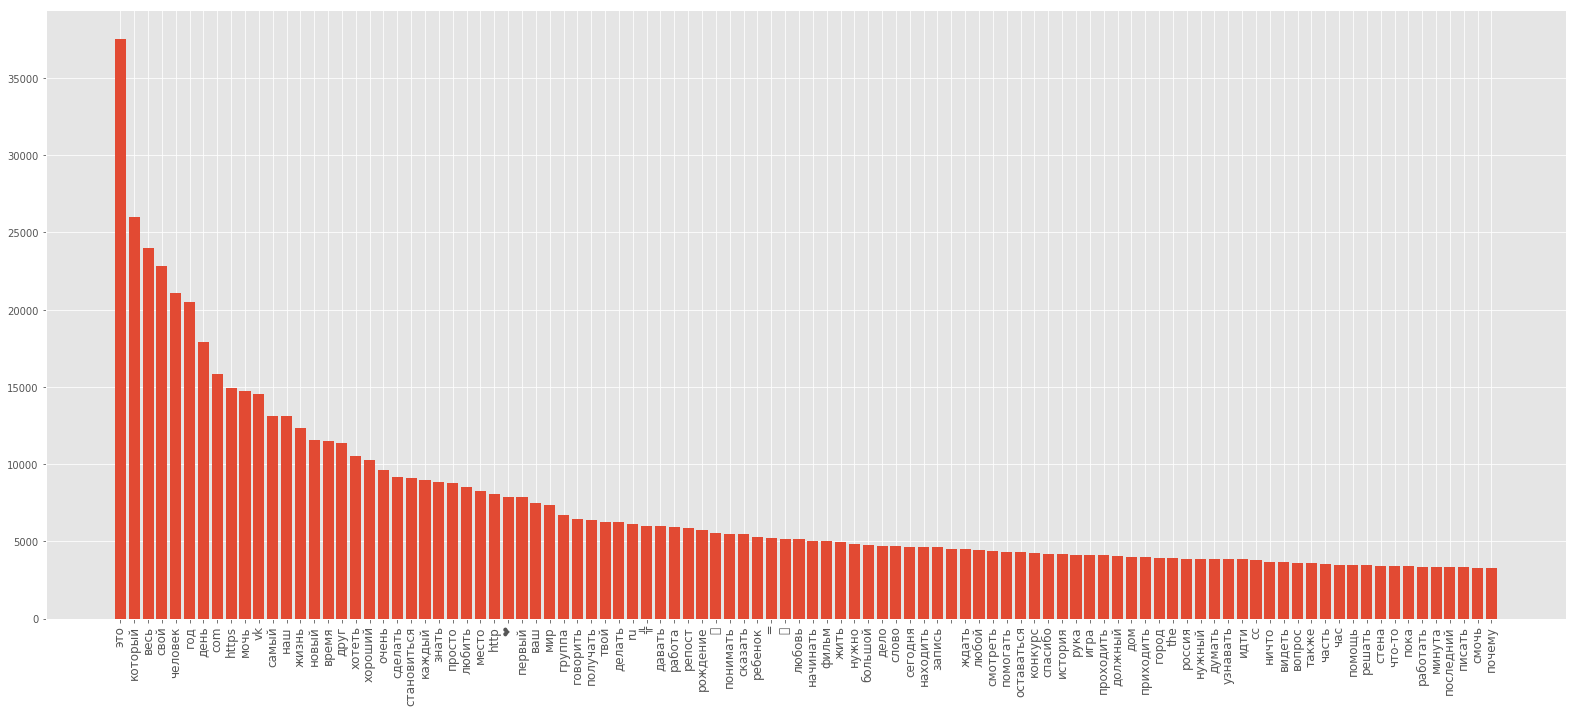

In [25]:
print('Размер словаря до фильтрации: {}'.format(len(dictionary)))
word_freq_plot(dictionary, corpus)

# можно сохранить картинку на компьютер для презентации или красоты dpi - её качество
# plt.savefig('Text/images/wordcount.png', dpi=500)

Повсюду одни сплошные предлоги и частицы с местоимениями. Эти слова часто встречаются в разных текстах и не несут абсолютно никакой смысловой нагрузки. Как уже говорилось ранее, такие слова называют стоп-словами. Если не выкинуть их из модели, они всплывут в каждой теме и всё зашумят. Можете попробовать на досуге построить с ними свою модель. Для построения адекватной модели от них необходимо избавиться.

Для борьбы с такими словами используется два подхода. В первом подходе такие слова зачищают с помощью специального списка из стоп-слов. Во втором подходе словарь фильтруют по частоте. Обычно его фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти, а также увеличения числа наблюдений для оценки каждого коэффициента) и очень частые слова (в целях повышения интерпретируемости тем).

Отфильтруем словарь по частоте и избавимся от всяких часто употребляемых стоп-слов. Заодно выбросим очень редкие слова, так как по ним ничего нельзя определенно сказать, а переобчаться под них мы не хотим.

Размер словаря после фильтрации: 24679


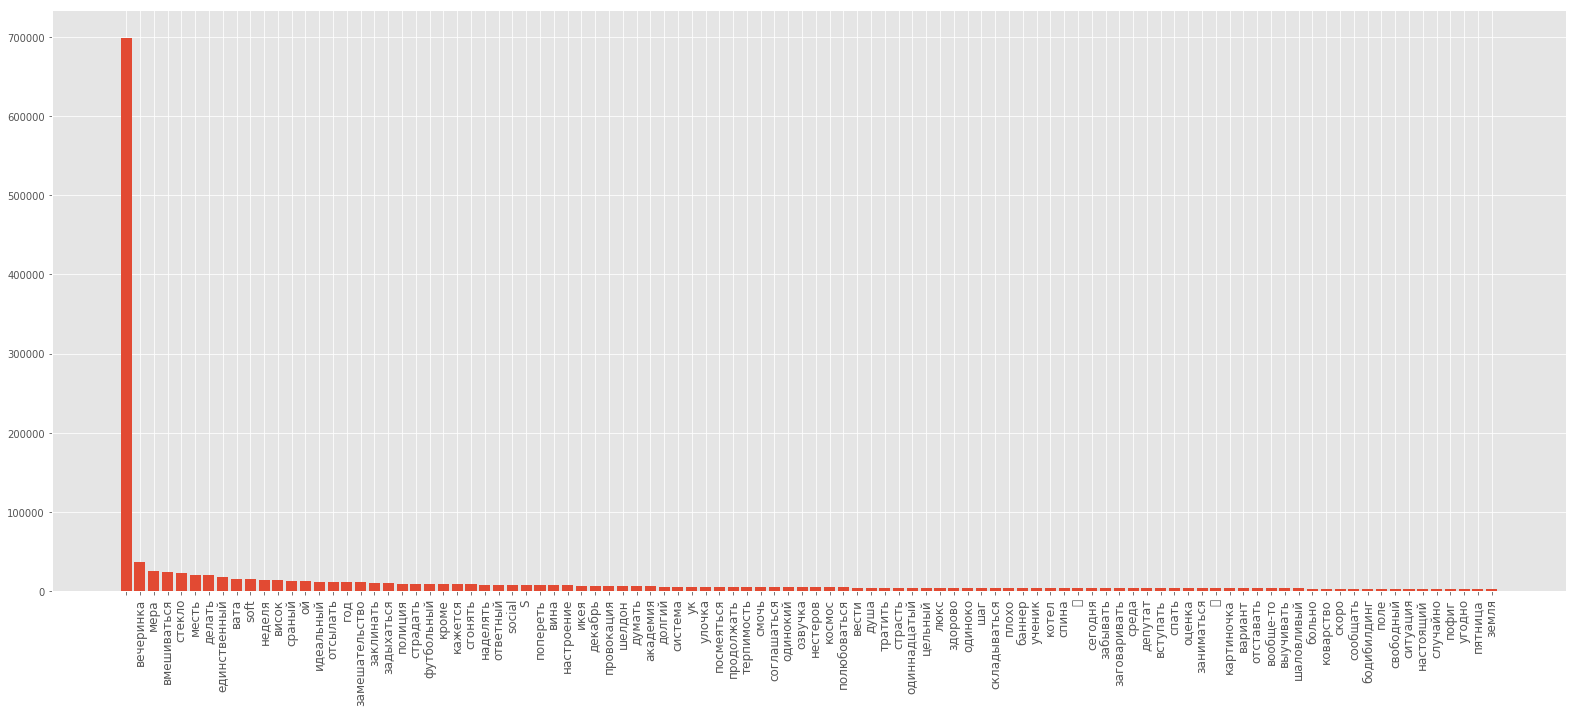

In [26]:
# слово должно встретиться хотябы 10 раз и не более чем в 50% документов
dictionary.filter_extremes(no_below=10, no_above=0.5)

print('Размер словаря после фильтрации: {}'.format(len(dictionary)))
word_freq_plot(dictionary, corpus)

In [27]:
# составляем корпус документов по отфиьлтрованному словарю
corpus = [dictionary.doc2bow(text) for text in texts_prep]  

## 4.2 Наша первая LDA модель. 

Обучим модель с $20$ тематиками. Обычно непонятно сколько тематик надо выбрать. Пробуют разное число на неочень больших выборках, и смотрят насколько хорошо получилось либо с точки зрения разных сложных метрик, либо с точки зрения здравого смысла. Мы будем пользоваться вторым. Надеюсь, что у нас он есть.

Учить будем [распаралеленный вариант модели,](https://radimrehurek.com/gensim/models/ldamulticore.html) чтобы побыстрее выучилась. ;) 

In [28]:
%%time

T = 20

lda_model =  models.ldamulticore.LdaMulticore(corpus=corpus,       # корпус для обучения
                                             id2word=dictionary,   # словарь для обучения
                                             num_topics=T,         # число тематик, которые мы выделяем
                                             random_state=42,      # чтобы воспроизводилось при перезапуске
                                             passes=20)            # число проходов по коллекции документов 
                                                                   # (если долго работает, уменьшите его!)

CPU times: user 5min 36s, sys: 1min 27s, total: 7min 3s
Wall time: 3min 49s


Сохраним модель.  Она училась долго. Негоже ей пропадать. 

In [29]:
!mkdir lda_model

In [30]:
# Сохранение модели
model_path = 'lda_model/'

lda_model.save(model_path + "ldamodel")
np.save(model_path + 'explog', lda_model .expElogbeta)

In [31]:
!ls -lh lda_model/

total 15816
-rw-r--r--  1 fulyankin  staff   1,9M 13 дек 03:03 explog.npy
-rw-r--r--  1 fulyankin  staff   150K 13 дек 03:03 ldamodel
-rw-r--r--  1 fulyankin  staff   1,9M 13 дек 03:03 ldamodel.expElogbeta.npy
-rw-r--r--  1 fulyankin  staff   1,1M 13 дек 03:03 ldamodel.id2word
-rw-r--r--  1 fulyankin  staff   2,7M 13 дек 03:03 ldamodel.state


Теперь мы можем посмотреть для каждого документа распределение по темам. Например, для первого документа оно выглядит вот так: 

In [32]:
lda_model.get_document_topics(corpus[299])

[(3, 0.09606333),
 (4, 0.47565675),
 (6, 0.113815874),
 (11, 0.10059242),
 (14, 0.12433385),
 (17, 0.033678655),
 (19, 0.05498673)]

In [33]:
print(texts_prep[299][:50])

['Evening', 'trading', 'floor', '😌', 'вышка', 'это', 'семинар', 'матстат', 'проходить', 'улица', 'преподаватель', 'раздавать', 'мороженое', '😎', 'музыка', 'Noize', 'MC', 'is', 'always', 'ready', 'to', 'make', 'some', 'noise', '💣', 'презентация', 'альбом', 'царь', 'гора', 'это', 'воистину', 'царский', 'альбом', '😎', 'ждать', 'ноябрь', '⌛', 'ровный', 'эстонский', 'полотно', '🇪', '🇪', 'наваливать', 'встречок', 'садовый', '😎', 'позволять', '😄', 'оказываться', 'забросить']


Вопрос только в том, что эти тематики обозначают. 

# 5. Интерпретация тематик

In [34]:
# Загрузка модели
ldamodel = models.ldamodel.LdaModel.load(model_path + "ldamodel")

expElogbeta = np.load(model_path + 'ldamodel.expElogbeta.npy')
ldamodel.expElogbeta = expElogbeta

T = ldamodel.num_topics # число тематик 
T

20

In [35]:
ldamodel.get_document_topics(corpus[99])

[(4, 0.4499422), (11, 0.5100073), (14, 0.025630899)]

In [36]:
topics = ldamodel.show_topics(num_topics=T, num_words=20, formatted=False)

for i,top in enumerate(topics):
    print(i, [item[0] for item in top[1]],'\n')

0 ['🏻', 'vk', 'это', 'https', 'com', 'cc', 'весь', 'который', 'подробно', 'свой', 'человек', 'скидка', '🔥', 'руб', 'http', 'цена', 'год', 'ᅠ', 'новый', '✅'] 

1 ['❤', 'это', '🔥', 'любить', '😍', '😂', '🖤', 'хотеть', 'свой', 'человек', '🏻', 'который', '💜', 'весь', '😎', 'жизнь', '💥', 'просто', 'знать', 'самый'] 

2 ['●', 'масло', 'добавлять', 'г', 'яйцо', 'л', 'минута', 'соль', 'сахар', 'тесто', 'вода', 'ингредиент', 'приготовление', 'мука', 'сыр', 'ложка', 'шт', 'ст', 'это', 'нарезать'] 

3 ['год', 'который', 'альбом', 'это', 'свой', 'фильм', 'новый', 'песня', 'группа', 'весь', 'музыка', 'время', 'The', 'самый', 'становиться', 'первый', 'человек', 'история', 'мочь', 'день'] 

4 ['это', 'человек', 'свой', 'весь', 'который', 'жизнь', 'мочь', 'любить', 'день', 'год', 'знать', 'хотеть', 'самый', 'просто', 'друг', 'говорить', 'очень', 'твой', 'хороший', 'время'] 

5 ['это', 'который', 'год', 'весь', 'свой', 'https', 'человек', 'мочь', 'ru', 'время', 'http', 'наш', 'com', 'работа', 'новый', 'са

In [96]:
themes_names = {
     0: 'скидки цены',
     1: 'добрая тема',
     2: 'рецепты',
     3: 'новые релизы',
     4: '???_1',
     5: 'учёба',
     6: '???_2',
     7: 'спортивные победы',
     8: 'конкурсы',   
     9: '???_3',
     10: 'конкурсы',
     11: 'музыка',
     12: '???_4',
     13: 'уход за собой',
     14: '???_5',
     15: 'приюты помощь',
     16: '???_6',
     17: 'кино',
     18: 'ML и python',
     19: '???_7'
 }

# заглушка, если мне влом будет всё проинтерпретировать
#themes_names = {i:'cluster_{}'.format(i) for i in range(T)}

Построим для каждой темы облака из слов (мы так уже делали в прошлых семинарах, когда говорили про тексты. 

In [38]:
from wordcloud import WordCloud  # Пакет для построения облаков слов

def getTopicWords(topic_number, lda_30_topics, scaling=10000):
    """
        Возвращает склеенные в текст слова топика, отмасштабированные по вероятности
    """
    # забираем слова и вероятности из топиков
    topic = lda_30_topics[topic_number][1]
    # инициализируем пустой лист для хранения текста
    topic_multiplied = []
    # проходимся по всем словам топика
    for word, prob in topic:
        # повторяем слово N раз, где N = int(word_probability * scaling)
        topic_multiplied.append([word] * int(prob*scaling))
    
    # склеиваем все слова в один текст
    topic_multiplied = sum(topic_multiplied, [])
    topic_multiplied = ",".join(topic_multiplied)
    
    return topic_multiplied

Достали топики.

In [39]:
topics = ldamodel.show_topics(num_topics=T, num_words=500, formatted=False)

Строим картинки!

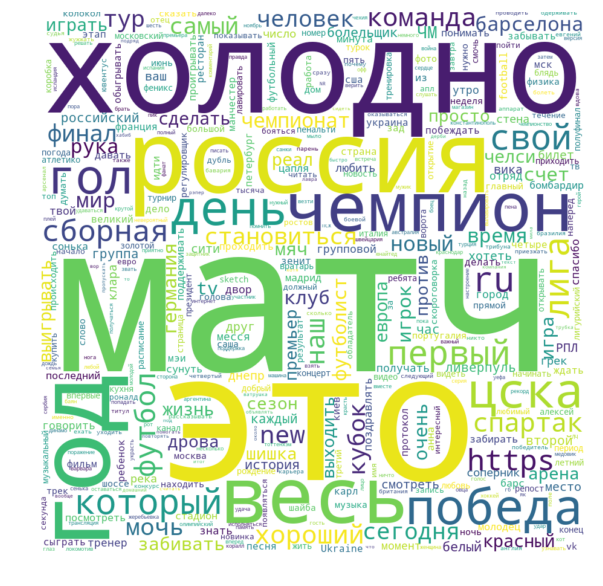

In [136]:
wordcloud = WordCloud(background_color="white", max_words=2000, width=900, height=900, collocations=False)

wordcloud = wordcloud.generate(getTopicWords(7, topics, scaling=10000))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Если хочется, можно построить сразу все картинки :)

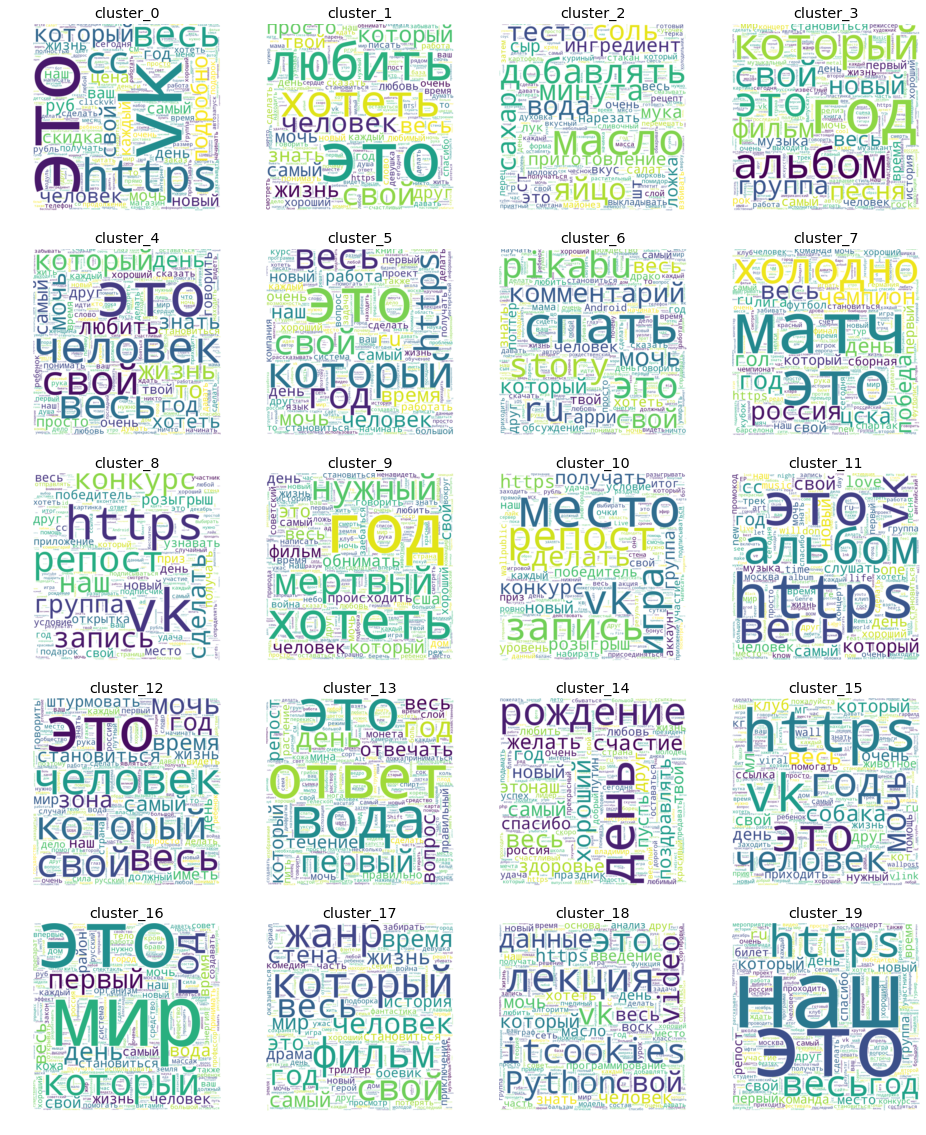

In [52]:
fig = plt.figure(figsize=(16, 20))
for i in range(T):
    ax = fig.add_subplot(5, 4, i+1)
    ax.grid(False)
    ax.axis('off')

    wordcloud = WordCloud(background_color="white", max_words=2000, width=900, height=900, collocations=False)
    wc = wordcloud.generate(getTopicWords(i, topics, scaling=10000))
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title("{}".format(themes_names[i]))
    
# сохраняем картинку для презы или ещё чего, если надо
# plt.savefig('clusters.png', dpi=450)

Корреляция между тематиками. 

In [78]:
# матрица тем
Phi = ldamodel.state.get_lambda()
print(Phi.shape)

S = pd.DataFrame(Phi.T).corr()

(20, 24679)


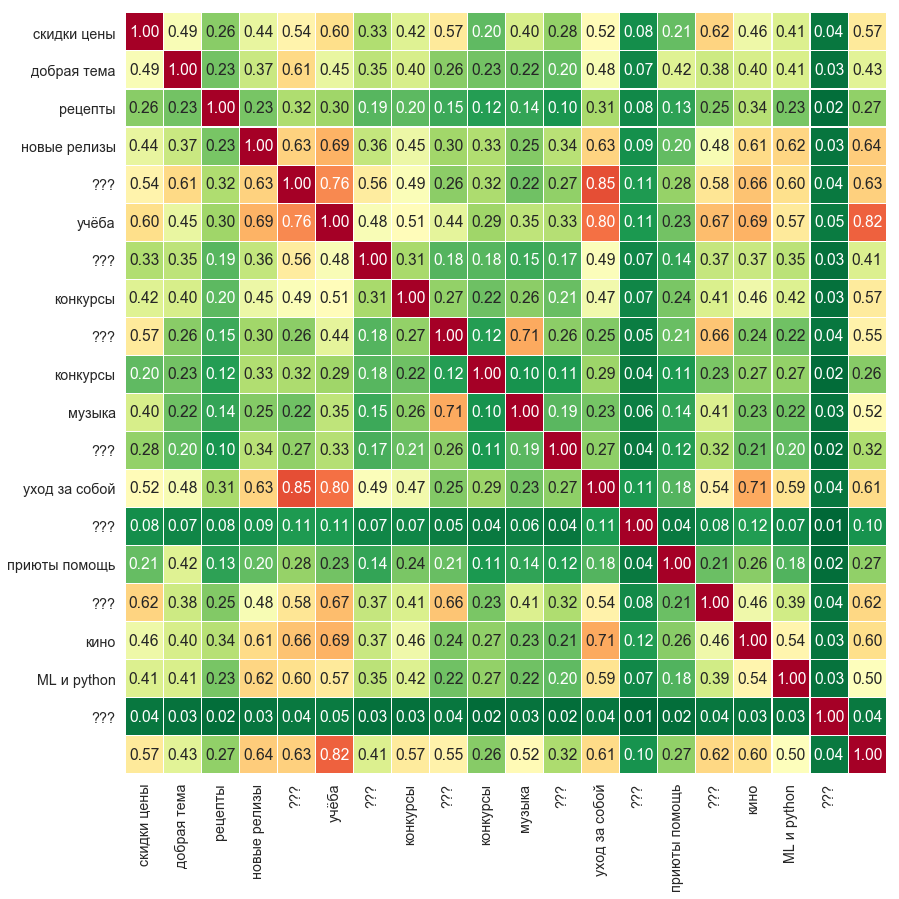

In [79]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(14, 14))
sns.heatmap(S, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(themes_names.values()), 
            xticklabels=list(themes_names.values()),
            cbar=False);

# 6. Визуализация тематик

С помощью специального пакета можно построить для анализа тематик небольшую визуализацию. Если модель тяжёлая, она будет строиться долго. Если пакета нет, можно установить его, запустив в ячейке `pip install pyLDAvis`.

In [41]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.070527  0.014451       1        1  26.432217
5     -0.030252 -0.065158       2        1  12.184019
19     0.066292 -0.060967       3        1   8.413202
12    -0.114190 -0.027806       4        1   7.057561
8      0.182074  0.015568       5        1   6.442089
3     -0.058235 -0.108785       6        1   5.402436
17    -0.087634 -0.049478       7        1   5.109468
11     0.044585 -0.139625       8        1   5.047188
2     -0.064098  0.203660       9        1   4.418964
0      0.032874  0.044428      10        1   3.385466
1      0.042969  0.068126      11        1   3.180220
14     0.131007  0.112674      12        1   2.595502
16    -0.092487  0.021950      13        1   1.888705
9     -0.085264 -0.046404      14        1   1.772837
10     0.237573 -0.003977      15        1   1.522038
15     0.001014 -0.013045      16        1   1.460235
6     -0.078600 -0.004490      17        1   1.299786
7      0.018155 -0.037854      18        1   1.178960
13    -0.100138  0.128011      19        1   0.649991
18     0.024881 -0.051281      20        1   0.559105, topic_info=      Category          Freq              Term         Total  loglift  logprob
21737  Default   4647.000000                 ═   4647.000000  30.0000  30.0000
842    Default  15313.000000               com  15313.000000  29.0000  29.0000
858    Default  14048.000000                vk  14048.000000  28.0000  28.0000
155    Default  17791.000000              день  17791.000000  27.0000  27.0000
754    Default  37656.000000               это  37656.000000  26.0000  26.0000
6410   Default   4008.000000                 ⠀   4008.000000  25.0000  25.0000
12     Default  14567.000000             https  14567.000000  24.0000  24.0000
760    Default   7872.000000                 ❤   7872.000000  23.0000  23.0000
1434   Default   8332.000000             место   8332.000000  22.0000  22.0000
1917   Default   5652.000000          рождение   5652.000000  21.0000  21.0000
127    Default  20517.000000               год  20517.000000  20.0000  20.0000
8168   Default   2345.000000                 █   2345.000000  19.0000  19.0000
4740   Default   2322.000000                 🌈   2322.000000  18.0000  18.0000
1912   Default   5791.000000            репост   5791.000000  17.0000  17.0000
641    Default   2895.000000             спать   2895.000000  16.0000  16.0000
271    Default  26070.000000           который  26070.000000  15.0000  15.0000
11     Default   7910.000000              http   7910.000000  14.0000  14.0000
69     Default  23954.000000              весь  23954.000000  13.0000  13.0000
2916   Default   3746.000000               the   3746.000000  12.0000  12.0000
733    Default  21165.000000           человек  21165.000000  11.0000  11.0000
3483   Default   4588.000000            запись   4588.000000  10.0000  10.0000
2674   Default   2826.000000                 🎉   2826.000000   9.0000   9.0000
2282   Default   5067.000000                 🏻   5067.000000   8.0000   8.0000
19     Default   6094.000000                ru   6094.000000   7.0000   7.0000
2742   Default   5525.000000                 🔥   5525.000000   6.0000   6.0000
593    Default  22916.000000              свой  22916.000000   5.0000   5.0000
3218   Default   3019.000000                 🎁   3019.000000   4.0000   4.0000
727    Default  10441.000000            хотеть  10441.000000   3.0000   3.0000
15194  Default   1509.000000                 →   1509.000000   2.0000   2.0000
3524   Default   4165.000000           конкурс   4165.000000   1.0000   1.0000
...        ...           ...               ...           ...      ...      ...
15255  Topic20     66.750549            Python    302.985901   3.6739  -5.7216
8410   Topic20     68.141846             video    349.781189   3.5509  -5.7010
4324   Topic20    110.645660            лекция   1067.026123   2.9203  -5.2162
1007

# 7. Сохраняем таблички c тематическими профилями 

Сделаем и сохраним матрицу встречаемости тем на разных стенах. Это наш основной продукт. 

In [86]:
%%time
th_df = [ ]  # матрица документы на темы 

for item in corpus:
    dct = dict(zip(range(T), [0]*T))
    dct.update(dict(ldamodel.get_document_topics(item)))
    th_df.append(dct)
    
th_df = pd.DataFrame(th_df)  

CPU times: user 33.4 s, sys: 12.2 s, total: 45.6 s
Wall time: 12.6 s


In [97]:
th_df.columns = list(themes_names.values())
th_df.shape

(8539, 20)

In [98]:
th_df.head()

скидки цены  добрая тема   рецепты  новые релизы     ???_1     учёба  \
0     0.000000     0.082882  0.000000      0.016007  0.468083  0.155485   
1     0.050000     0.050000  0.050000      0.050000  0.050000  0.050000   
2     0.000000     0.000000  0.000000      0.000000  0.699083  0.000000   
3     0.012526     0.012526  0.012526      0.012526  0.012526  0.012526   
4     0.000000     0.000000  0.000000      0.000000  0.549585  0.360140   

      ???_2  спортивные победы  конкурсы     ???_3  конкурсы    музыка  \
0  0.000000           0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.050000           0.050000  0.050000  0.050000  0.050000  0.050000   
2  0.000000           0.039229  0.000000  0.000000  0.000000  0.000000   
3  0.012526           0.012526  0.012526  0.762003  0.012526  0.012526   
4  0.000000           0.000000  0.000000  0.000000  0.000000  0.000000   

      ???_4  уход за собой     ???_5  приюты помощь     ???_6      кино  \
0  0.222359       0.000000  0.000000       0.000000  0.000000  0.000000   
1  0.050000       0.050000  0.050000       0.050000  0.050000  0.050000   
2  0.000000       0.000000  0.000000       0.000000  0.000000  0.249524   
3  0.012526       0.012526  0.012526       0.012526  0.012526  0.012526   
4  0.052866       0.000000  0.000000       0.000000  0.000000  0.000000   

   ML и python     ???_7  
0     0.000000  0.052308  
1     0.050000  0.050000  
2     0.000000  0.000000  
3     0.012526  0.012526  
4     0.000000  0.027259

Самые частые темы по максимальной встречаемости.

In [99]:
from collections import Counter
top_th = Counter([themes_names[item] for item in th_df.get_values().argmax(axis=1)])
top_th.most_common()

[('скидки цены', 2507),
 ('???_1', 1809),
 ('конкурсы', 734),
 ('добрая тема', 732),
 ('???_7', 429),
 ('музыка', 413),
 ('учёба', 408),
 ('???_5', 288),
 ('новые релизы', 259),
 ('???_4', 203),
 ('кино', 197),
 ('рецепты', 103),
 ('приюты помощь', 91),
 ('???_3', 90),
 ('???_2', 84),
 ('???_6', 76),
 ('спортивные победы', 72),
 ('ML и python', 25),
 ('уход за собой', 19)]

Допишем в табличку названия групп. __Если бы мы скачали для каждого пользователя какие-нибудь социаль-демографические характеристики, например, пол, или города или ещё что-то, мы могли бы их тоже дописать в эту таблицу. Это могло бы нам помочь посмотреть какие именно тематики всплывают по разным соц-дем категориям. Возможно,там были бы какие-то интересные закономерности.__  Не побрезгуйте в домашках соц-демом и что-нибудь скачайте по нему.

In [100]:
th_df['group'] = group
th_df.head()

скидки цены  добрая тема   рецепты  новые релизы     ???_1     учёба  \
0     0.000000     0.082882  0.000000      0.016007  0.468083  0.155485   
1     0.050000     0.050000  0.050000      0.050000  0.050000  0.050000   
2     0.000000     0.000000  0.000000      0.000000  0.699083  0.000000   
3     0.012526     0.012526  0.012526      0.012526  0.012526  0.012526   
4     0.000000     0.000000  0.000000      0.000000  0.549585  0.360140   

      ???_2  спортивные победы  конкурсы     ???_3  ...    музыка     ???_4  \
0  0.000000           0.000000  0.000000  0.000000  ...  0.000000  0.222359   
1  0.050000           0.050000  0.050000  0.050000  ...  0.050000  0.050000   
2  0.000000           0.039229  0.000000  0.000000  ...  0.000000  0.000000   
3  0.012526           0.012526  0.012526  0.762003  ...  0.012526  0.012526   
4  0.000000           0.000000  0.000000  0.000000  ...  0.000000  0.052866   

   уход за собой     ???_5  приюты помощь     ???_6      кино  ML и python  \
0       0.000000  0.000000       0.000000  0.000000  0.000000     0.000000   
1       0.050000  0.050000       0.050000  0.050000  0.050000     0.050000   
2       0.000000  0.000000       0.000000  0.000000  0.249524     0.000000   
3       0.012526  0.012526       0.012526  0.012526  0.012526     0.012526   
4       0.000000  0.000000       0.000000  0.000000  0.000000     0.000000   

      ???_7      group  
0  0.052308  hse_memes  
1  0.050000  hse_memes  
2  0.000000  hse_memes  
3  0.012526  hse_memes  
4  0.027259  hse_memes  

[5 rows x 21 columns]

In [112]:
th_df.to_csv('theme_data.tsv', sep='\t', index=False) # сохранили данные

# 8. Тематические профили подписчиков по группам.

In [130]:
th_df = pd.read_csv('theme_data.tsv', sep='\t')  # считали данные
th_df.drop('Unnamed: 0', axis=1, inplace=True) # КРИВО СОХРАНИЛИ ААААА
th_df.head()

скидки цены  добрая тема   рецепты  новые релизы     ???_1     учёба  \
0     0.000000     0.082882  0.000000      0.016007  0.468083  0.155485   
1     0.050000     0.050000  0.050000      0.050000  0.050000  0.050000   
2     0.000000     0.000000  0.000000      0.000000  0.699083  0.000000   
3     0.012526     0.012526  0.012526      0.012526  0.012526  0.012526   
4     0.000000     0.000000  0.000000      0.000000  0.549585  0.360140   

      ???_2  спортивные победы  конкурсы     ???_3  ...    музыка     ???_4  \
0  0.000000           0.000000  0.000000  0.000000  ...  0.000000  0.222359   
1  0.050000           0.050000  0.050000  0.050000  ...  0.050000  0.050000   
2  0.000000           0.039229  0.000000  0.000000  ...  0.000000  0.000000   
3  0.012526           0.012526  0.012526  0.762003  ...  0.012526  0.012526   
4  0.000000           0.000000  0.000000  0.000000  ...  0.000000  0.052866   

   уход за собой     ???_5  приюты помощь     ???_6      кино  ML и python  \
0       0.000000  0.000000       0.000000  0.000000  0.000000     0.000000   
1       0.050000  0.050000       0.050000  0.050000  0.050000     0.050000   
2       0.000000  0.000000       0.000000  0.000000  0.249524     0.000000   
3       0.012526  0.012526       0.012526  0.012526  0.012526     0.012526   
4       0.000000  0.000000       0.000000  0.000000  0.000000     0.000000   

      ???_7      group  
0  0.052308  hse_memes  
1  0.050000  hse_memes  
2  0.000000  hse_memes  
3  0.012526  hse_memes  
4  0.027259  hse_memes  

[5 rows x 21 columns]

Сделаем группировку по всем темам и посмотрим как именно они выглядят по подписчикам.

In [131]:
groups_themes = th_df.groupby('group').mean()
groups_themes

скидки цены  добрая тема   рецепты  новые релизы     ???_1  \
group                                                                      
amdevs           0.023797     0.115658  0.019087      0.059259  0.185333   
bad_memes1       0.064289     0.099079  0.045495      0.030056  0.196303   
bad_memes2       0.044175     0.124439  0.035720      0.036562  0.101236   
female_memes     0.084546     0.140869  0.032196      0.038186  0.143488   
fizkek           0.016617     0.047364  0.015451      0.055126  0.202730   
hse_memes        0.013849     0.067186  0.013028      0.047125  0.245250   
ml_memes         0.014441     0.021243  0.012415      0.065898  0.167710   
ukr_memes        0.035253     0.180241  0.020696      0.034786  0.178295   
wtf_memes        0.022841     0.053903  0.063796      0.047673  0.267165   

                 учёба     ???_2  спортивные победы  конкурсы     ???_3  \
group                                                                     
amdevs        0.033675  0.030803           0.023177  0.079813  0.038253   
bad_memes1    0.030621  0.027634           0.022884  0.094577  0.022133   
bad_memes2    0.036774  0.032126           0.034362  0.085733  0.031867   
female_memes  0.030797  0.031092           0.028985  0.061201  0.034208   
fizkek        0.099480  0.026123           0.026167  0.056716  0.018660   
hse_memes     0.076737  0.019191           0.021980  0.043853  0.026053   
ml_memes      0.197457  0.019534           0.016432  0.045413  0.015030   
ukr_memes     0.021980  0.032437           0.021796  0.086190  0.029167   
wtf_memes     0.032494  0.011608           0.020430  0.150051  0.013745   

              конкурсы.1    музыка     ???_4  уход за собой     ???_5  \
group                                                                   
amdevs          0.043743  0.079755  0.055218       0.015421  0.034000   
bad_memes1      0.042276  0.027345  0.038623       0.019254  0.048667   
bad_memes2      0.068084  0.036791  0.035809       0.030966  0.055792   
female_memes    0.031063  0.052317  0.036317       0.026823  0.053703   
fizkek          0.022240  0.076394  0.057004       0.012893  0.042216   
hse_memes       0.015136  0.111453  0.045037       0.010883  0.061269   
ml_memes        0.015564  0.109656  0.052096       0.009974  0.032968   
ukr_memes       0.052276  0.048846  0.030463       0.019368  0.054155   
wtf_memes       0.018685  0.025412  0.039654       0.008107  0.050254   

              приюты помощь     ???_6      кино  ML и python     ???_7  
group                                                                   
amdevs             0.026685  0.022186  0.029575     0.019967  0.047659  
bad_memes1         0.025737  0.029477  0.076057     0.017345  0.027763  
bad_memes2         0.034768  0.033431  0.055363     0.029687  0.040535  
female_memes       0.031206  0.031219  0.031668     0.025248  0.035361  
fizkek             0.024133  0.027396  0.027010     0.011217  0.123254  
hse_memes          0.018537  0.017339  0.026399     0.011305  0.096063  
ml_memes           0.026265  0.016398  0.020063     0.013272  0.117310  
ukr_memes          0.028626  0.022590  0.031721     0.018516  0.033540  
wtf_memes          0.023508  0.023015  0.064115     0.004019  0.052107

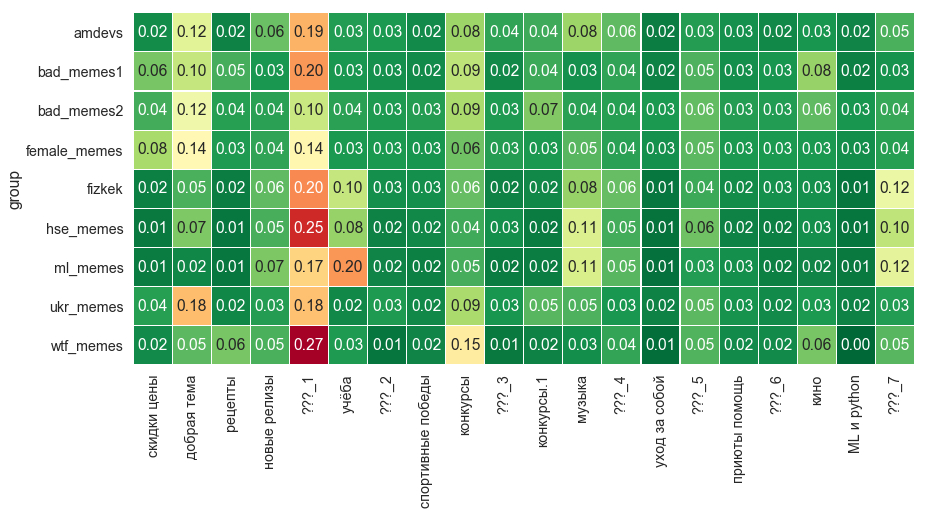

In [132]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(14, 14))

sns.heatmap(groups_themes, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(groups_themes.index), 
            xticklabels=list(groups_themes.columns),
            cbar=False);

Для красоты картинки занулим все маргинальные темы.

In [133]:
groups_themes[groups_themes < 0.03] = 0

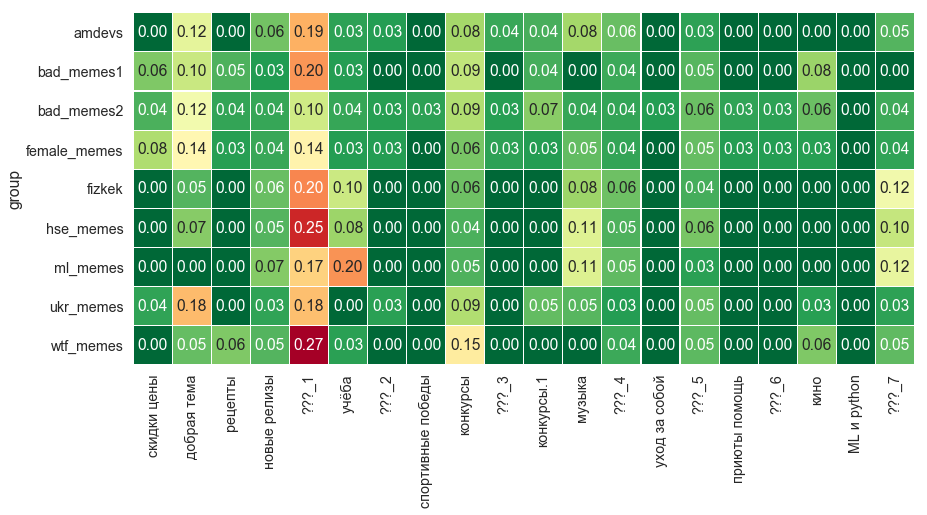

In [134]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(14, 14))

sns.heatmap(groups_themes, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(groups_themes.index), 
            xticklabels=list(groups_themes.columns),
            cbar=False);

Если бы мы скачали из контакта побольше данных по соц-дему, можно было бы посмотреть и на другие группировки!

# 9. Похожесть групп между собой.

Похожесть групп будем мерять косинусным расстоянием! 

In [138]:
from scipy.spatial.distance import cosine

n = groups_themes.shape[0]  # выясняем число групп
R = np.zeros((n,n))         # заводим матрицу расстояний 


for i in range(n):
    vect1 = groups_themes.iloc[i]     # выделяем вектор для первого 
    for j in range(n):
        vect2 = groups_themes.iloc[j] # выделяем второй вектор 
        R[i,j] = cosine(vect1, vect2) # ищем косинусное расстояние

Чем больше коминус, тем сильнее группы не похожи друг на друга по своим подписчикам!

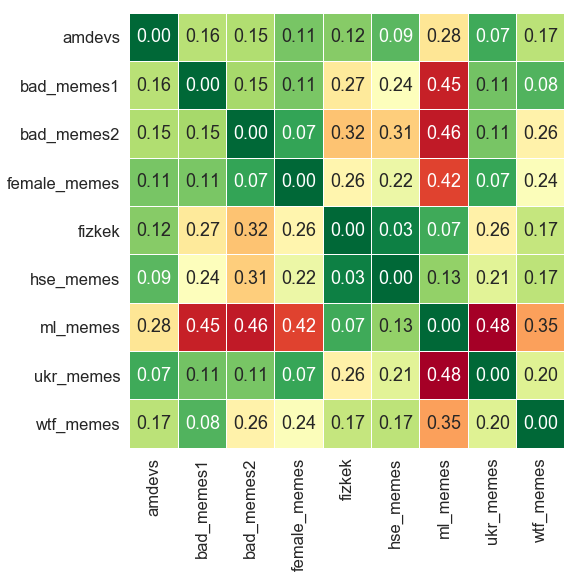

In [140]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(8, 8))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=list(groups_themes.index), 
            xticklabels=list(groups_themes.index), cbar=False);

# 10.  Что делать, если темы плохо выделились? 

* Больше предобработки данных, надо выкинуть больше стоп-слов, чтобы из-за них не возникали мусорные тематики 
* Больше итераций обучения модели 
* Попробовать выделять другое количество тематик, не факт что выбрали самое клёвое $T$ из всех возможных! 
* Можно попробовать поперебирать $T$ и позамерять такую метрику качества как перплексия, но об этом почитаете в интернете. 
* Можно собрать ещё данных. 

# Полезные материалы

* [Тетрадка с семинара по API вконтакте](https://nbviewer.jupyter.org/github/FUlyankin/HSE_Data_Culture/blob/master/ML_for_marketing_2019/sems/sem10_vk/vk_parser_full.ipynb) 
* [Расширенная тетрадка по мотивам семинара,](https://nbviewer.jupyter.org/github/FUlyankin/HSE_Data_Culture/blob/master/ML_for_marketing_2019/sems/sem10_vk/vk_parser_download.ipynb)  которой я скачивал мемы 
* [Туториал по тому как качать вконтакте,](https://nbviewer.jupyter.org/github/FUlyankin/ekanam_grand_research/blob/master/0.%20vk_parser_tutorial.ipynb) в нём есть функция, которая ускоряет скачку в 25 раз. Она обычно довольно полезна для скачки лайков и комментариев. 

* [Небольшой проект от меня и моего Димы](https://github.com/DmitrySerg/top-russian-music) про рэпчик и тематическое моделирование 
* [Дима рассказывает про этот проект на PyData](https://www.youtube.com/watch?v=MEBjnGaHsmw)  (видос полчаса без регистрации и смс)